In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import emoji
import nltk
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from transformers import BertTokenizerFast
from transformers import TFBertModel
from tensorflow import keras
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from gensim.utils import tokenize
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from collections import Counter


C:\Users\khand\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
dataset  =pd.read_excel('dataset.xlsx')
dataset .head(10)

Label                   ID  \
0     1  s899597685077852160   
1     1  s902209214411546625   
2     1  s903717322879369218   
3     1  s902550240611500032   
4     1  s897855659579916289   
5     1  s898747016016220160   
6     1  s899704547521830913   
7     1  s897068979528900608   
8     1  s899443273533722625   
9     1  s888151387824988160   

                                                Text  \
0     Off highway crash at 104th Ave and Westrnin...   
1    ( of ) Yes, when all construction is complet...   
2    Hi Jordyn, the incident happened at Hampton ...   
3    how about zebra or zipper barriers between t...   
4    Is Exit off WB highway closed for construction?   
5    NB traffic will be rerouted through one of t...   
6    New issue EB QEW on the ramp to Cawthra, the...   
7    PFD members working incident at Summerdale &amp   
8    take the Jersey turnpike off ||||||||Dean am...   
9    The road is still closed while crews work to...   

                                            Location  
0   Miami, Miami-Dade County, Florida, United States  
1            2609 W Jefferson St Joliet, IL 60435 US  
2              24651 Cedar Rd Lyndhurst, OH 44124 US  
3                    74 Brick Plz Brick, NJ 08723 US  
4  3125 E Indian School Rd Ste 101 Phoenix, AZ 85...  
5  5715 S Eastern Ave Ste 105 Las Vegas, NV 89119 US  
6               15100 W 119th St Olathe, KS 66062 US  
7       8061 Dani Dr Ste 140 Fort Myers, FL 33966 US  
8  Manhattan, New York County, New York, United S...  
9    2350 Sunrise Blvd Ste 3 Gold River, CA 95670 US

# Data Analysis

In [3]:
tweets_per_country = dataset['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')
print(tweets_per_country)

                                             Location  counts
0   Manhattan, New York County, New York, United S...    2249
1      Orlando, Orange County, Florida, United States     802
2     London, Greater London, England, United Kingdom     541
3        Anchorage, Alaska, 99501-2118, United States     386
4                                   Borneo, Indonesia     366
5      Queens, Queens County, New York, United States     318
6     Washington, District of Columbia, United States     293
7                             New York, United States     221
8     Brooklyn, Kings County, New York, United States     211
9   University of Alaska Fairbanks, 1731, College,...     195
10   The Bronx, Bronx County, New York, United States     194
11   Miami, Miami-Dade County, Florida, United States     177
12                             Georgia, United States     137


C:\Users\khand\AppData\Local\Temp\ipykernel_11896\1962077513.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.barplot(x='Location', y='counts', data=tweets_per_country, edgecolor='black', ci=False, palette='Spectral')


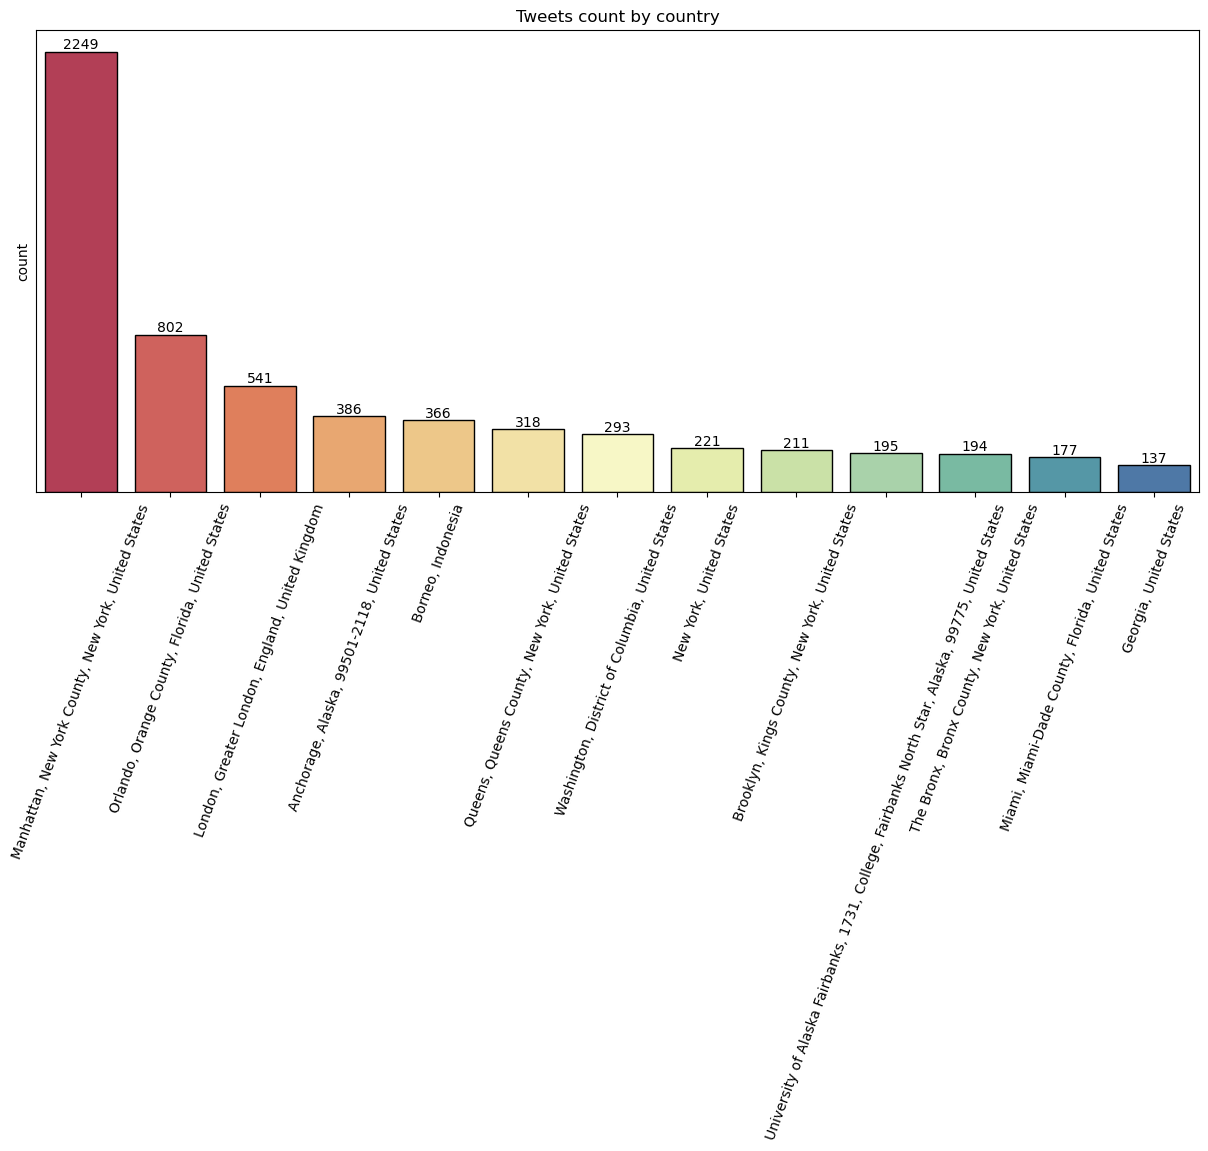

In [150]:
# Trier le DataFrame tweets_per_country par la colonne 'counts' dans l'ordre décroissant
tweets_per_country = tweets_per_country.sort_values(by='counts', ascending=False)

plt.figure(figsize=(15,6))
ax = sns.barplot(x='Location', y='counts', data=tweets_per_country, edgecolor='black', ci=False, palette='Spectral')

# Ajouter les valeurs au graphique
for index, value in enumerate(tweets_per_country['counts']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title('Tweets count by country')
plt.xticks(rotation=70)
plt.yticks([])
plt.ylabel('count')
plt.xlabel('')
plt.show()



# Data preprocessing

**Remove duplicate tweets**

In [4]:
dataset.drop_duplicates(subset='Text',inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47650 entries, 0 to 48614
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Label     47646 non-null  object
 1   ID        47650 non-null  object
 2   Text      47649 non-null  object
 3   Location  46052 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [5]:
#Supprimer les lignes qui contient la Valeurs NAN dans la colonne Text
dataset.dropna(subset=['Text'], inplace=True)

In [6]:
#supprimer les lignes où la longueur du texte est inférieure ou égale à 4
dataset = dataset[dataset['Text'].apply(lambda x: len(x) > 4)]

In [7]:
dataset = dataset[['Text','Label','Location']]
dataset.head()

Text Label  \
0     Off highway crash at 104th Ave and Westrnin...     1   
1    ( of ) Yes, when all construction is complet...     1   
2    Hi Jordyn, the incident happened at Hampton ...     1   
3    how about zebra or zipper barriers between t...     1   
4    Is Exit off WB highway closed for construction?     1   

                                            Location  
0   Miami, Miami-Dade County, Florida, United States  
1            2609 W Jefferson St Joliet, IL 60435 US  
2              24651 Cedar Rd Lyndhurst, OH 44124 US  
3                    74 Brick Plz Brick, NJ 08723 US  
4  3125 E Indian School Rd Ste 101 Phoenix, AZ 85...

In [8]:
from cleantext import clean

**custom functions to clean the text of the tweets.**

In [9]:
import re

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
def strip_all_entities(text): 
    # Remplace les retours à la ligne et les nouvelles lignes par des espaces, et met le texte en minuscules
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() 
    
       # Supprime les mentions Twitter (@username) et les URLs (http:// ou https://)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) 
    
    # Supprime les caractères non-ASCII
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    
    # Crée une liste de caractères interdits comprenant la ponctuation et certains caractères spécifiques
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list) # Crée une table de traduction pour supprimer les caractères interdits
    text = text.translate(table) # Supprime les caractères interdits du texte
    return text
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) 
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

def lower_token(tokens): 
    return [w.lower() for w in tokens]

all_stopwords_gensim = STOPWORDS
def removeStopWords(tokens): 
    return [word for word in tokens if word not in all_stopwords_gensim and word.isalpha()]
#Selon objectif du algorithme on choisi le fonction du preprocessing 

In [10]:
texts_new = []
for t in dataset.Text:
    if isinstance(t, str):
        cleaned_text = remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(remove_emoji(t)))))
        texts_new.append(cleaned_text)
    else:
    
        texts_new.append("") 


In [11]:
dataset['text_clean'] = texts_new
dataset['text_clean'].head()

0    off highway crash at 104th ave and westrninste...
1    of yes when all construction is complete there...
2    hi jordyn the incident happened at hampton but...
3    how about zebra or zipper barriers between the...
4       is exit off wb highway closed for construction
Name: text_clean, dtype: object

In [12]:
#Calculer langueurde chaque texte en mots
text_len = []
for text in dataset.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [13]:
dataset['text_len'] = text_len
print(f" Dataset SHAPE: {dataset.shape}")

 Dataset SHAPE: (47648, 5)


**Data Preprocessing CNN Model**

In [14]:
tokens_CNN = [list(tokenize(sen)) for sen in dataset.Text]
print(tokens_CNN[:10])

[['Off', 'highway', 'crash', 'at', 'th', 'Ave', 'and', 'Westrninster', 'Blvd'], ['of', 'Yes', 'when', 'all', 'construction', 'is', 'complete', 'there', 'will', 'be', 'three', 'lanes', 'in', 'bot'], ['Hi', 'Jordyn', 'the', 'incident', 'happened', 'at', 'Hampton', 'but', 'NB', 'highway', 'is', 'closed', 'atâ'], ['how', 'about', 'zebra', 'or', 'zipper', 'barriers', 'between', 'the', 'bike', 'vehicle', 'lanes', 'iâ'], ['Is', 'Exit', 'off', 'WB', 'highway', 'closed', 'for', 'construction'], ['NB', 'traffic', 'will', 'be', 'rerouted', 'through', 'one', 'of', 'the', 'SB', 'lanes', 'Travel', 'in', 'both', 'directions', 'will', 'cont'], ['New', 'issue', 'EB', 'QEW', 'on', 'the', 'ramp', 'to', 'Cawthra', 'there', 's', 'a', 'stall', 'in', 'the', 'Right', 'Lane'], ['PFD', 'members', 'working', 'incident', 'at', 'Summerdale', 'amp'], ['take', 'the', 'Jersey', 'turnpike', 'off', 'Dean', 'ambrose', 'drive', 'make', 'a', 'left', 'right', 'inâ'], ['The', 'road', 'is', 'still', 'closed', 'while', 'crews

In [15]:
lower_tokens_CNN = [lower_token(token) for token in tokens_CNN]
print(lower_tokens_CNN[:10])

[['off', 'highway', 'crash', 'at', 'th', 'ave', 'and', 'westrninster', 'blvd'], ['of', 'yes', 'when', 'all', 'construction', 'is', 'complete', 'there', 'will', 'be', 'three', 'lanes', 'in', 'bot'], ['hi', 'jordyn', 'the', 'incident', 'happened', 'at', 'hampton', 'but', 'nb', 'highway', 'is', 'closed', 'atâ'], ['how', 'about', 'zebra', 'or', 'zipper', 'barriers', 'between', 'the', 'bike', 'vehicle', 'lanes', 'iâ'], ['is', 'exit', 'off', 'wb', 'highway', 'closed', 'for', 'construction'], ['nb', 'traffic', 'will', 'be', 'rerouted', 'through', 'one', 'of', 'the', 'sb', 'lanes', 'travel', 'in', 'both', 'directions', 'will', 'cont'], ['new', 'issue', 'eb', 'qew', 'on', 'the', 'ramp', 'to', 'cawthra', 'there', 's', 'a', 'stall', 'in', 'the', 'right', 'lane'], ['pfd', 'members', 'working', 'incident', 'at', 'summerdale', 'amp'], ['take', 'the', 'jersey', 'turnpike', 'off', 'dean', 'ambrose', 'drive', 'make', 'a', 'left', 'right', 'inâ'], ['the', 'road', 'is', 'still', 'closed', 'while', 'crews

In [16]:
filtered_words = [removeStopWords(sen) for sen in lower_tokens_CNN]
dataset['Text_Final'] = [' '.join(sen) for sen in filtered_words]
dataset['tokens'] = filtered_words
print(filtered_words[:10])

[['highway', 'crash', 'th', 'ave', 'westrninster', 'blvd'], ['yes', 'construction', 'complete', 'lanes', 'bot'], ['hi', 'jordyn', 'incident', 'happened', 'hampton', 'nb', 'highway', 'closed', 'atâ'], ['zebra', 'zipper', 'barriers', 'bike', 'vehicle', 'lanes', 'iâ'], ['exit', 'wb', 'highway', 'closed', 'construction'], ['nb', 'traffic', 'rerouted', 'sb', 'lanes', 'travel', 'directions', 'cont'], ['new', 'issue', 'eb', 'qew', 'ramp', 'cawthra', 's', 'stall', 'right', 'lane'], ['pfd', 'members', 'working', 'incident', 'summerdale', 'amp'], ['jersey', 'turnpike', 'dean', 'ambrose', 'drive', 'left', 'right', 'inâ'], ['road', 'closed', 'crews', 'work', 'equipment', 'willâ']]


In [17]:
train= dataset.copy()
train= train[['Text_Final', 'tokens', 'Label', 'Location']]
print(train)


                                              Text_Final  \
0                 highway crash th ave westrninster blvd   
1                    yes construction complete lanes bot   
2      hi jordyn incident happened hampton nb highway...   
3            zebra zipper barriers bike vehicle lanes iâ   
4                    exit wb highway closed construction   
...                                                  ...   
48610  know basfâ s employee resource group lgbt frie...   
48611                dropped food floor eat s chart help   
48612   fault sandy able offer loving girl pet free home   
48613          hey learn changing facebook hope helps cb   
48614  past years immigrant women boosted long term f...   

                                                  tokens Label  \
0          [highway, crash, th, ave, westrninster, blvd]     1   
1              [yes, construction, complete, lanes, bot]     1   
2      [hi, jordyn, incident, happened, hampton, nb, ...     1   
3      [zebra, 

In [18]:
num_words = 20000
 
tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train['Text_Final'].tolist())

In [19]:
word_index = tokenizer.word_index
print(tokenizer.word_index)
print('Found %s unique tokens.' % len(word_index))

{'unk': 12695, 'highway': 2, 'exit': 3, 'lane': 4, 'cleared': 5, 'updated': 6, 's': 7, 'blocked': 8, 'crash': 9, 'closed': 10, 'lanes': 11, 'right': 12, 'station': 13, 'incident': 14, 'traffic': 15, 'new': 16, 'pm': 17, 'amp': 18, 'st': 19, 'north': 20, 'rd': 21, 'left': 22, 'accident': 23, 'â': 24, 'construction': 25, 'south': 26, 'vehicle': 27, 'nb': 28, 'street': 29, 'sb': 30, 'mm': 31, 'th': 32, 'sr': 33, 'mile': 34, 'west': 35, 'east': 36, 'ramp': 37, 'road': 38, 'ave': 39, 'avenue': 40, 'update': 41, 'ðÿ': 42, 'directions': 43, 'eb': 44, 'wb': 45, 'delays': 46, 'turnpike': 47, 'disabled': 48, 't': 49, 'southbound': 50, 'northbound': 51, 'blvd': 52, 'pa': 53, 'w': 54, 'line': 55, 'near': 56, 'roadwork': 57, 'help': 58, 'm': 59, 'planned': 60, 'miami': 61, 'roadway': 62, 'eastbound': 63, 'e': 64, 'thanks': 65, 'hi': 66, 'westbound': 67, 'today': 68, 'slow': 69, 'open': 70, 'nj': 71, 'clear': 72, 'b': 73, 'marker': 74, 'work': 75, 'delay': 76, 'time': 77, 'dade': 78, 'use': 79, 'tra

In [20]:
word_index = tokenizer.word_index
word_counts = tokenizer.word_counts

# Créer une liste de tuples (word, index, count) en parcourant word_index et word_counts
data = [(word, index, word_counts[word]) for word, index in word_index.items()]

# Créer un DataFrame à partir de la liste de tuples
df = pd.DataFrame(data, columns=['Word', 'Index', 'Occurrences'])

# Trier le DataFrame par l'index (pour avoir les mots les plus fréquents en premier)
df_sorted = df.sort_values(by='Index').reset_index(drop=True)

# Afficher les 10 premiers mots
print(df_sorted.head(10))

      Word  Index  Occurrences
0  highway      2        14421
1     exit      3         6611
2     lane      4         5860
3  cleared      5         5015
4  updated      6         4808
5        s      7         4776
6  blocked      8         4760
7    crash      9         4240
8   closed     10         4223
9    lanes     11         3816


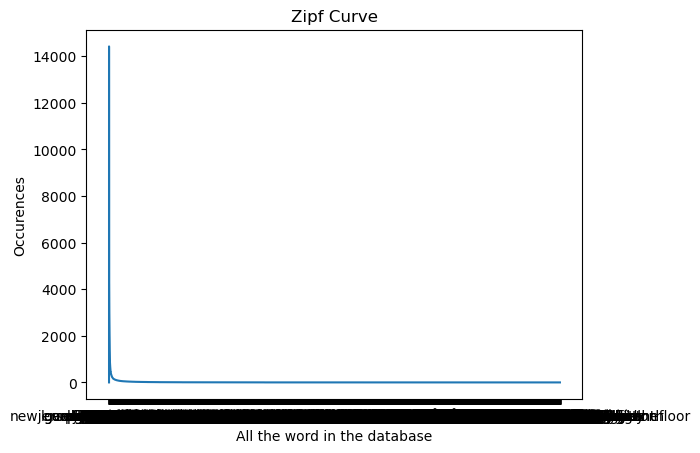

In [26]:
import matplotlib.pyplot as plt
plt.plot(df['Word'], df['Occurrences'])
# naming the x axis
plt.xlabel('All the word in the database')
# naming the y axis
plt.ylabel('Occurences')

# giving a title to my graph
plt.title('Zipf Curve')

# function to show the plot
plt.show()

**data deeper cleaning BERT Model**

In [21]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [22]:
token_lens = []
for txt in dataset['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_len=np.max(token_lens)

In [23]:
print(len(token_lens))

47648


In [24]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 44


In [25]:
token_lens = []
for i, txt in enumerate(dataset['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    word_tokens = tokenizer.convert_ids_to_tokens(tokens)
    print(f"index {i}: {word_tokens}")
    if len(tokens) > 80:
        print(f"INDEX: {i}, TEXT: {txt}")


index 0: ['[CLS]', 'off', 'highway', 'crash', 'at', '104', '##th', 'ave', 'and', 'west', '##rn', '##ins', '##ter', 'b', '##l', '##vd', '[SEP]']
index 1: ['[CLS]', 'of', 'yes', 'when', 'all', 'construction', 'is', 'complete', 'there', 'will', 'be', 'three', 'lanes', 'in', 'bot', '[SEP]']
index 2: ['[CLS]', 'hi', 'jo', '##rdy', '##n', 'the', 'incident', 'happened', 'at', 'hampton', 'but', 'n', '##b', 'highway', 'is', 'closed', 'at', '[SEP]']
index 3: ['[CLS]', 'how', 'about', 'zebra', 'or', 'zipper', 'barriers', 'between', 'the', 'bike', '##ve', '##hic', '##le', 'lanes', 'i', '[SEP]']
index 4: ['[CLS]', 'is', 'exit', 'off', 'wb', 'highway', 'closed', 'for', 'construction', '[SEP]']
index 5: ['[CLS]', 'n', '##b', 'traffic', 'will', 'be', 're', '##routed', 'through', 'one', 'of', 'the', 'sb', 'lanes', 'travel', 'in', 'both', 'directions', 'will', 'con', '##t', '[SEP]']
index 6: ['[CLS]', 'new', 'issue', 'e', '##b', 'q', '##ew', 'on', 'the', 'ramp', 'to', 'ca', '##wt', '##hra', 'there', '##

index 1495: ['[CLS]', 'accident', 'with', 'injuries', 'on', 'southbound', 'highway', 'north', 'of', 'highway', 'in', 'san', 'lean', '##dro', 'left', 'and', 'center', 'lanes', 'blocked', '[SEP]']
index 1496: ['[CLS]', 'accident', 'with', 'injuries', 'accident', 'with', 'injuries', 'h', '##wy', 'mile', 'marker', 'med', '##ics', 'reporting', 'heavy', 'traffic', '##av', '##oid', 'area', '[SEP]']
index 1497: ['[CLS]', 'accident', 'with', 'injuries', '##m', '##va', 's', 'meadow', 'ave', '##s', 'us', 'highway', 'la', '##redo', '[SEP]']
index 1498: ['[CLS]', 'accident', 'with', 'injury', 'in', 'des', '##tre', '##han', 'on', 'highway', 'at', 'e', 'harding', 'st', 'traffic', 'no', '##la', '[SEP]']
index 1499: ['[CLS]', 'accident', 'with', 'injury', 'n', '##b', 'sr', 's', 'of', 'bay', 'ave', 'capitol', '##a', '[SEP]']
index 1500: ['[CLS]', 'accident', 'with', 'the', 'passing', 'lane', 'blocked', 'on', 'highway', 'mile', 'east', 'of', 'the', 'fish', 'creek', 'exit', 'at', 'mile', 'marker', 'at', '

index 2794: ['[CLS]', 'cleared', 'albany', 'accident', 'n', '##b', 'on', 'highway', 'exit', 'exit', '21', '##b', 'right', 'lane', 'open', 'incident', 'clear', 'traffic', 'normal', '[SEP]']
index 2795: ['[CLS]', 'cleared', 'albany', 'accident', 'n', '##b', 'on', 'highway', 'exit', '21', '##be', '##xi', '##t', '21', '##a', 'exit', 'ramp', 'to', 'new', 'baltimore', 'service', 'area', 'blocked', 'incident', 'clear', 'traffic', 'normal', '[SEP]']
index 2796: ['[CLS]', 'cleared', 'buffalo', 'accident', 'e', '##b', 'on', 'highway', 'at', 'exit', 'right', 'lane', 'blocked', 'incident', 'clear', 'delays', 'may', 'exist', '[SEP]']
index 2797: ['[CLS]', 'cleared', 'buffalo', 'accident', 'e', '##b', 'on', 'highway', 'exit', 'exit', 'left', 'lane', 'blocked', 'incident', 'clear', 'traffic', 'normal', '[SEP]']
index 2798: ['[CLS]', 'cleared', 'buffalo', 'accident', 'sb', 'on', 'highway', 'exit', 'exit', 'left', 'lane', 'blocked', 'incident', 'clear', 'traffic', 'normal', '[SEP]']
index 2799: ['[CLS]

index 4088: ['[CLS]', 'cleared', 'disabled', 'vehicle', 'n', '##b', 'on', 'highway', 'at', 'mm', '##16', '##5', 'in', 'fairfax', 'co', '##0', '##8', '##pm', '[SEP]']
index 4089: ['[CLS]', 'cleared', 'disabled', 'vehicle', 'n', '##b', 'on', 'highway', 'at', 'mm', '##28', '##3', 'in', 'woodstock', '##0', '##4', '##pm', '[SEP]']
index 4090: ['[CLS]', 'cleared', 'disabled', 'vehicle', 'n', '##b', 'on', 'highway', 'at', 'mm', '##44', 'in', 'fairfax', 'co', '##00', '##am', '[SEP]']
index 4091: ['[CLS]', 'cleared', 'disabled', 'vehicle', 'n', '##b', 'on', 'highway', 'at', 'mm', '##7', '##6', 'in', 'richmond', '##34', '##pm', '[SEP]']
index 4092: ['[CLS]', 'cleared', 'disabled', 'vehicle', 'n', '##b', 'on', 'highway', 'at', 'mm', '##8', '##7', 'in', 'hanover', 'co', '##56', '##pm', '[SEP]']
index 4093: ['[CLS]', 'cleared', 'disabled', 'vehicle', 'n', '##b', 'on', 'i', '##9', '##5', '##r', 'at', 'mm', '##14', '##7', 'in', 'stafford', 'co', '##50', '##pm', '[SEP]']
index 4094: ['[CLS]', 'cleared

index 5499: ['[CLS]', 'cleared', 'police', 'activity', 'in', 'miami', '##dad', '##e', 'on', 'sr', 'south', 'beyond', 'nw', 'st', 'all', 'lanes', 'blocked', 'last', 'updated', 'at', '38', '##pm', '[SEP]']
index 5500: ['[CLS]', 'cleared', 'police', 'activity', 'in', 'miami', '##dad', '##e', 'on', 'sr', 'west', 'at', 'nw', 'ave', 'left', 'lane', 'blocked', 'last', 'updated', 'at', '17', '##am', '[SEP]']
index 5501: ['[CLS]', 'cleared', 'police', 'activity', 'in', 'palm', 'beach', 'on', 'florida', '##s', 'turnpike', 'south', 'at', 'exit', 'glad', '##es', 'rd', 'on', '##ram', '##p', 'closed', 'all', 'lanes', 'blocked', 'last', 'updated', '[SEP]']
index 5502: ['[CLS]', 'cleared', 'police', 'activity', 'in', 'palm', 'beach', 'on', 'florida', '##s', 'turnpike', 'south', 'at', 'service', 'plaza', 'and', 'traffic', 'backed', 'up', 'until', 'beyond', 'southern', 'b', '##l', '##vd', 'all', '[SEP]']
index 5503: ['[CLS]', 'cleared', 'police', 'activity', 'in', 'polk', 'on', 'highway', 'east', 'befor

index 6893: ['[CLS]', 'construction', 'on', 'll', '##ine', 'both', 'directions', 'from', 'broadway', '##ea', '##ster', '##n', 'parkway', 'station', 'to', '8th', 'avenue', 'station', '[SEP]']
index 6894: ['[CLS]', 'construction', 'on', 'll', '##ine', 'both', 'directions', 'from', 'lori', '##mer', 'street', 'station', 'to', 'broadway', '##ea', '##ster', '##n', 'parkway', 'station', '[SEP]']
index 6895: ['[CLS]', 'construction', 'on', 'll', '##ine', 'both', 'directions', 'from', 'myrtle', 'avenue', 'station', 'to', 'rock', '##away', 'parkway', '##cana', '##rs', '##ie', 'station', '[SEP]']
index 6896: ['[CLS]', 'construction', 'on', 'm', '##4', '##bus', 'n', '##b', 'at', 'bra', '##od', '##way', '113', '##rd', 'street', '[SEP]']
index 6897: ['[CLS]', 'construction', 'on', 'm', '##86', '##sb', '##s', 'wb', 'at', 'st', 'at', 'lexington', 'av', 'bus', 'stop', 'temporarily', 'relocated', '[SEP]']
index 6898: ['[CLS]', 'construction', 'on', 'meadow', '##brook', '##sta', '##te', '##park', '##way'

index 8283: ['[CLS]', 'faye', '##tte', 'co', 'faye', '##tte', 'station', 'road', 'closed', 'through', 'june', 'for', 'road', 'repairs', '[SEP]']
index 8284: ['[CLS]', 'f', '##dot', 'wants', 'to', 'ease', 'congestion', 'for', 'motor', '##ists', 'traveling', 'between', 'tampa', 'amp', '[SEP]']
index 8285: ['[CLS]', 'fifth', 'avenue', 'protected', 'bike', 'lane', 'cyclists', 'have', 'something', 'to', 'celebrate', 'below', '23rd', 'street', 'lets', 'start', 'it', 'higher', '[SEP]']
index 8286: ['[CLS]', 'final', 'update', 'all', 'e', '##b', 'amp', '[SEP]']
index 8287: ['[CLS]', 'final', 'update', 'all', 'lanes', 'clear', 'on', 'highway', 'wb', 'at', 'military', 'highway', 'no', 'backup', 'remains', 'hr', '##tra', '##ffi', '##c', '[SEP]']
index 8288: ['[CLS]', 'final', 'update', 'all', 'lanes', 'have', 'reopened', 'on', 'highway', 'west', 'at', 'j', 'clyde', 'morris', 'b', '##l', '##vd', 'in', 'hr', '##tra', '##ffi', '##c', '[SEP]']
index 8289: ['[CLS]', 'final', 'update', 'all', 'lanes', 

index 9713: ['[CLS]', 'highway', '##wy', 'crash', 'wb', 'lane', 'blocked', 'near', 'sweet', '##water', 'station', 'jc', '##t', 'at', 'mile', '##post', 'expect', 'delays', 'w', '##yo', '##ro', '##ad', '[SEP]']
index 9714: ['[CLS]', 'hill', '##town', 't', '##w', '##p', 'bucks', '309', '##nb', 'jammed', 'approaching', 'the', 'bypass', 'due', 'to', 'a', 'serious', 'crash', 'in', 'the', 'left', 'lane', '[SEP]']
index 9715: ['[CLS]', 'hitting', 'the', 'road', 'this', 'am', 'add', 'lots', 'of', 'extra', 'time', 'on', 'major', 'h', '##wy', '##s', 'going', 'north', 'i', '##75', 'i', '##9', '##5', 'and', 'turnpike', 'have', 'many', 'slow', '[SEP]']
index 9716: ['[CLS]', 'holland', 'park', 'west', 'disabled', 'bus', 'southbound', 'pacific', 'motorway', 'at', 'k', '##lum', '##pp', 'road', 'clear', '[SEP]']
index 9717: ['[CLS]', 'holy', 'shit', 'i', 'just', 'saw', 'an', 'insane', 'accident', 'car', 'caught', 'on', 'fire', 'right', 'away', 'if', 'your', '##e', 'going', 'down', 'palm', 'heading', 'no

index 11190: ['[CLS]', 'mcc', '##lain', 'county', 'i', '##35', 'n', '##b', 'mile', 'marker', 'gold', '##sby', 'exit', 'has', 'the', 'outside', 'lane', 'closed', 'for', 'approximately', 'of', 'a', 'mile', '##te', '##g', '[SEP]']
index 11191: ['[CLS]', 'mcc', '##lain', 'county', 'i', '##35', 'sb', 'mile', 'marker', 'is', 'an', 'injury', 'accident', 'with', 'the', 'roadway', 'blocked', '##te', '##g', '[SEP]']
index 11192: ['[CLS]', 'mcc', '##lain', 'highway', 'northbound', 'mile', 'marker', 'non', '##in', '##ju', '##ry', 'collision', 'roadway', 'is', 'clear', 'ba', '##f', '[SEP]']
index 11193: ['[CLS]', 'mcc', '##lain', 'highway', 'southbound', 'mile', 'marker', 'non', '##in', '##ju', '##ry', 'collision', 'roadway', 'is', 'clear', 'ba', '##f', '[SEP]']
index 11194: ['[CLS]', 'mcc', '##lain', 'highway', 'southbound', 'state', 'highway', 'west', 'is', 'clear', 'ba', '##f', '[SEP]']
index 11195: ['[CLS]', 'mcc', '##lain', 'highway', 'southbound', 'state', 'highway', 'west', 'injury', 'accide

index 12462: ['[CLS]', 'norfolk', '##hi', '##gh', '##way', 'east', 'crash', 'update', '##t', '##wo', 'right', 'lanes', 'before', 'military', 'h', '##wy', 'have', 'reopened', 'traffic', 'is', 'moving', 'but', 'expect', 'major', 'delays', 'hr', '##tra', '##ffi', '##c', '[SEP]']
index 12463: ['[CLS]', 'norfolk', '##hi', '##gh', '##way', 'west', 'before', 'nor', '##view', 'ave', '##over', '##turn', '##ed', 'rv', 'right', 'lanes', 'blocked', 'expect', 'delays', 'hr', '##tra', '##ffi', '##c', '[SEP]']
index 12464: ['[CLS]', 'norfolk', '##hr', '##bt', 'crash', 'update', '##i', '##64', '##w', '##ball', 'lanes', 'clear', 'traffic', 'moving', 'hr', '##tra', '##ffi', '##c', '[SEP]']
index 12465: ['[CLS]', 'norfolk', '##i', '##64', '##e', 'at', 'highway', 'interchange', 'motorcycle', 'crash', '##le', '##ft', 'two', 'lanes', 'blocked', 'traffic', 'getting', 'by', 'in', 'right', 'lane', 'expect', 'delays', 'hr', '##tra', '##ffi', '##c', '[SEP]']
index 12466: ['[CLS]', 'norfolk', 'highway', 'wb', 'ne

index 13870: ['[CLS]', 'road', '##work', 'on', 'highway', 'westbound', 'between', 'pa', 'munster', 'and', 'pa', 'munster', 'there', 'is', 'a', 'lane', 'restriction', '[SEP]']
index 13871: ['[CLS]', 'road', '##work', 'on', 'highway', 'westbound', 'between', 'pa', 'south', '25th', 'st', 'and', 'pa', 'north', 'there', 'is', 'a', 'lane', 'restriction', '[SEP]']
index 13872: ['[CLS]', 'road', '##work', 'on', 'highway', 'westbound', 'between', 'pa', 'north', 'and', 'til', '##gh', '##man', 'st', 'there', 'is', 'a', 'lane', 'restriction', '[SEP]']
index 13873: ['[CLS]', 'road', '##work', 'on', 'highway', 'westbound', 'between', 'pa', 'south', 'and', 'til', '##gh', '##man', 'st', 'there', 'is', 'a', 'lane', 'restriction', '[SEP]']
index 13874: ['[CLS]', 'road', '##work', 'on', 'highway', 'westbound', 'between', 'wood', 'ave', '##13', '##th', 'st', 'and', 'pa', 'south', '25th', 'st', 'there', 'is', 'a', 'traffic', 'disruption', '[SEP]']
index 13875: ['[CLS]', 'road', '##work', 'on', 'highway', '

index 15106: ['[CLS]', 'traffic', 'alert', 'route', 'north', '##so', '##uth', 'crash', 'route', '##32', 'south', '##br', '##un', '##swick', 'multi', 'mile', 'del', '##a', '[SEP]']
index 15107: ['[CLS]', 'traffic', 'alert', 'rte', '417', '##cl', '##osed', 'kill', 'buck', 'rd', 'to', 'highway', 'salamanca', 'due', 'to', 'accident', 'highway', 'e', '##b', 'closed', 'exit', 'all', '##egan', '##y', 'state', 'park', 'to', 'exit', 'rte', '[SEP]']
index 15108: ['[CLS]', 'traffic', 'alert', 'rte', 'from', 'slade', 'ave', 'to', 'ridge', 'rd', 'due', 'to', 'accident', 'in', 'west', 'seneca', 'up', 'to', 'hr', '##s', '[SEP]']
index 15109: ['[CLS]', 'traffic', 'alert', 'salem', 'highway', 'southbound', 'mile', 'to', 'the', 'ma', 'state', 'line', 'heavy', 'traffic', 'slow', 'down', '[SEP]']
index 15110: ['[CLS]', 'traffic', 'alert', 'southbound', 'lane', 'on', 'marguerite', 'p', '##k', '##wy', 'from', 'mustang', 'run', 'to', 'ala', '##rco', '##n', 'will', 'be', 'closed', 'for', 'median', 'work', 'un

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



index 24793: ['[CLS]', 'hey', 'ab', '##hi', '##jit', 'we', 'decided', 'to', 'send', 'along', 'a', 'little', 'something', 'while', 'you', 'count', 'down', 'the', 'days', '[SEP]']
index 24794: ['[CLS]', 'hey', 'ab', '##his', '##he', '##k', 'if', 'your', 'account', 'has', 'been', 'taken', 'over', 'by', 'someone', 'else', 'please', 'secure', 'it', 'here', 'mg', '[SEP]']
index 24795: ['[CLS]', 'hey', 'ab', '##his', '##he', '##k', 'please', 'visit', 'our', 'help', 'center', 'to', 'learn', 'more', 'about', 'issues', 'with', 'log', '##in', 'thank', 'you', 'cb', '[SEP]']
index 24796: ['[CLS]', 'hey', 'adam', 'some', 'styles', 'should', 'be', 'rest', '##ock', '##ing', 'next', 'week', '[SEP]']
index 24797: ['[CLS]', 'hey', 'adam', 'thank', 'you', 'for', 'sharing', 'your', 'idea', 'feel', 'free', 'to', 'share', 'more', 'feedback', 'here', 'mg', '[SEP]']
index 24798: ['[CLS]', 'hey', 'ai', '##leen', 'can', 'you', 'please', 'have', 'your', 'aunt', 'visit', 'the', 'help', 'center', 'to', 'learn', 'mo

index 26141: ['[CLS]', 'love', 'your', 'musical', 'choices', '##que', '##ens', '##uga', '##r', '[SEP]']
index 26142: ['[CLS]', 'loved', 'ale', '##vel', 'chemistry', 'would', 'definitely', 'recommend', 'it', 'best', 'course', '[SEP]']
index 26143: ['[CLS]', 'loved', 'the', 'ballad', 'version', 'of', 'your', 'song', 'last', 'night', 'on', 'love', '##ma', '##ke', '##the', '##world', '##gor', '##ound', 'awesome', 'job', '[SEP]']
index 26144: ['[CLS]', 'luz', '##ia', 'is', 'stunning', '##gl', '##ad', 'its', 'getting', 'a', 'shout', 'out', '[SEP]']
index 26145: ['[CLS]', 'mt', 'li', '##gg', '##ett', 'who', 'lined', 'a', 'highway', 'with', 'politically', 'provocative', 'art', 'dies', 'at', '[SEP]']
index 26146: ['[CLS]', 'make', 'a', 'green', 'choice', 'is', 'an', 'option', 'at', 'our', 'properties', 'you', 'are', 'not', 'ob', '##liga', '##ted', 'to', 'part', '##ake', '[SEP]']
index 26147: ['[CLS]', 'make', 'a', 'green', 'choice', 'is', 'our', 'sustainability', 'program', 'but', 'well', 'defi

index 27602: ['[CLS]', 'we', 'love', 'our', 'best', '##fan', '##s', 'too', 'thanks', 'for', 'spreading', 'the', 'mb', '##lov', '##e', '[SEP]']
index 27603: ['[CLS]', 'we', 'love', 'our', 'star', '##wood', 'preferred', 'pets', 'glad', 'to', 'hear', 'your', '##e', 'enjoying', 'your', 'stay', 'with', 'your', 'furry', 'friend', 'keep', 'living', 'sp', '##gli', '##fe', '[SEP]']
index 27604: ['[CLS]', 'we', 'love', 'reading', 'ku', '##dos', 'emails', 'we', 'will', 'be', 'sure', 'to', 'pass', 'along', 'to', 'management', 'for', 'you', 'so', 'staff', 'can', 'be', 'recognized', '[SEP]']
index 27605: ['[CLS]', 'we', 'love', 'seeing', 'you', 'for', 'breakfast', 'hope', 'to', 'see', 'you', 'soon', '[SEP]']
index 27606: ['[CLS]', 'we', 'love', 'seeing', 'you', 'thanks', 'for', 'coming', 'by', '[SEP]']
index 27607: ['[CLS]', 'we', 'love', 'that', 'you', 'love', 'our', 'sweet', 'tea', 'emile', '##e', 'visit', 'us', 'again', 'soon', '[SEP]']
index 27608: ['[CLS]', 'we', 'love', 'these', 'photos', 'tha

index 28930: ['[CLS]', 'this', 'is', 'crazy', 'sobs', 'utah', 'hospital', 'nurse', 'as', 'cop', 'rough', '##s', 'her', 'up', 'arrests', 'her', 'for', 'doing', 'her', 'job', '[SEP]']
index 28931: ['[CLS]', 'this', 'is', 'fascinating', 'but', 'also', 'terrifying', 'me', 'describing', 'every', 'single', 'thing', 'in', '[SEP]']
index 28932: ['[CLS]', 'this', 'is', 'just', 'another', 'way', 'of', 'saying', 'here', 'my', 'heart', 'has', 'been', 'preparing', 'for', 'you', 'all', 'day', '[SEP]']
index 28933: ['[CLS]', 'this', 'is', 'no', 'accident', 'this', 'is', 'a', 'political', 'philosophy', 'put', 'into', 'action', 'and', 'a', 'triumphant', 'one', 'at', 'that', '[SEP]']
index 28934: ['[CLS]', 'this', 'memorial', 'weekend', 'i', 'hope', 'you', '##ll', 'join', 'me', 'in', 'acts', 'of', 'remembrance', 'president', 'obama', '[SEP]']
index 28935: ['[CLS]', 'this', 'mothers', 'day', 'say', 'thank', 'you', 'say', 'i', 'love', 'you', 'president', 'obama', '[SEP]']
index 28936: ['[CLS]', 'to', 'me'

index 30412: ['[CLS]', 'active', 'investigation', 't', '##pd', 'on', 'scene', 'where', 'a', 'bus', 'traveling', 'southbound', 'armenia', 'approaching', 'swan', '##n', 'crash', 'into', 'a', 'business', '[SEP]']
index 30413: ['[CLS]', 'actor', 'dan', 'richardson', 'amp', '[SEP]']
index 30414: ['[CLS]', 'actor', 'wears', 'a', 'ralph', 'lauren', 'purple', 'label', 'wool', 'and', 'cash', '##mere', 'suit', 'in', 'the', 'march', 'issue', 'of', '[SEP]']
index 30415: ['[CLS]', 'actress', 'round', '##table', 'more', 'stars', 'on', 'nu', '##dity', 'and', 'the', 'diva', 'label', '[SEP]']
index 30416: ['[CLS]', 'actual', 'picture', 'of', 'how', 'well', 'im', 'keeping', 'it', 'together', 'rn', '[SEP]']
index 30417: ['[CLS]', 'actually', 'that', 'would', 'be', 'th', '##ic', '##thic', 'not', 'th', '##ic', '##c', 'but', 'th', '##ic', '[SEP]']
index 30418: ['[CLS]', 'ac', '##yl', 'chloride', '##s', 'will', 'form', 'the', 'este', '##r', 'and', 'hc', '##l', '[SEP]']
index 30419: ['[CLS]', 'ad', 'fred', 'g

index 31797: ['[CLS]', 'china', 'just', 'agreed', 'that', 'the', 'us', 'will', 'be', 'allowed', 'to', 'sell', 'beef', 'and', 'other', 'major', 'products', 'into', 'china', 'once', 'again', 'this', 'is', 'real', 'news', '[SEP]']
index 31798: ['[CLS]', 'china', 'over', '##take', '##s', 'france', 'as', 'the', 'worlds', 'second', '##lar', '##ges', '##t', 'wine', '##gr', '##owing', 'region', '[SEP]']
index 31799: ['[CLS]', 'chin', '##tz', '##y', 'cherry', 'chants', 'and', 'chi', '##tch', '##at', '[SEP]']
index 31800: ['[CLS]', 'chip', '##ot', '##le', 'marketing', 'ex', '##ec', 'indicted', 'in', 'major', 'crack', '##down', 'on', 'cocaine', 'buyers', 'in', 'new', 'york', '[SEP]']
index 31801: ['[CLS]', 'chip', '##ot', '##le', 'suspend', '##s', 'pork', 'sales', 'over', 'pig', 'treatment', '[SEP]']
index 31802: ['[CLS]', 'choose', 'from', 'one', 'of', 'embroidered', 'dog', 'breeds', 'and', 'enter', 'the', 'polo', '##pu', '##pc', '##onte', '##st', 'for', 'your', 'dog', 'to', 'be', 'rules', 'in',

index 33283: ['[CLS]', 'food', 'quiz', 'what', 'am', 'i', 'guess', 'and', 'you', 'could', 'win', 'a', 'gift', 'card', 'from', 'amazon', '[SEP]']
index 33284: ['[CLS]', 'food', 'quiz', 'what', 'am', 'i', 'give', 'it', 'your', 'best', 'shot', '[SEP]']
index 33285: ['[CLS]', 'food', '##borne', 'illnesses', 'are', 'residual', 'threats', 'following', 'major', 'storms', 'like', 'harvey', 'pick', 'up', 'tips', 'from', '[SEP]']
index 33286: ['[CLS]', 'food', '##ies', 'under', 'should', 'join', 'us', 'and', 'greens', 'at', 'next', 'week', 'for', 'game', 'night', '[SEP]']
index 33287: ['[CLS]', 'foods', '##er', '##vic', '##e', 'blogs', 'share', 'your', 'thoughts', 'and', 'expertise', 'w', 'our', 'community', 'come', 'on', 'over', '[SEP]']
index 33288: ['[CLS]', 'foods', '##er', '##vic', '##e', 'marketing', 'and', 'discussed', 'in', 'min', 'magazine', 'this', 'week', '[SEP]']
index 33289: ['[CLS]', 'foods', '##er', '##vic', '##e', 'operator', 'needs', 'to', 'do', 'a', 'category', 'review', 'for',

index 34797: ['[CLS]', 'i', 'hope', 'your', '##e', 'enjoying', 'the', 'ni', '##tu', '##ni', '##yo', 'music', 'video', '##kee', '##p', 'download', '##ing', 'and', 'streaming', 'watch', 'the', 'video', 'now', '[SEP]']
index 34798: ['[CLS]', 'i', 'just', 'booked', 'my', 'flight', 'to', 'see', 'this', 'november', 'yes', 'baby', 'wait', 'for', 'me', '[SEP]']
index 34799: ['[CLS]', 'i', 'just', 'checked', 'in', 'at', 'ex', '##qui', '##sit', '##o', 'restaurant', 'with', 'mp', '##lus', '##pl', '##ace', '##s', 'download', 'today', '[SEP]']
index 34800: ['[CLS]', 'i', 'just', 'checked', 'in', 'at', 'ind', '##ig', '##ma', 'with', 'mp', '##lus', '##pl', '##ace', '##s', 'download', 'today', '[SEP]']
index 34801: ['[CLS]', 'i', 'just', 'don', '##t', 'know', 'anymore', '[SEP]']
index 34802: ['[CLS]', 'i', 'just', 'earned', 'the', 'hopped', 'up', 'level', 'badge', 'on', '[SEP]']
index 34803: ['[CLS]', 'i', 'just', 'heard', 'a', 'loud', 'ass', 'plane', 'go', 'over', 'my', 'house', 'amp', '[SEP]']
index

index 36225: ['[CLS]', 'latest', 'update', 'from', 'nh', '##c', 'shows', 'little', 'change', 'of', 'tropical', 'storm', 'harvey', '##s', 'location', 'or', 'strength', 'in', 'the', 'past', 'hours', '[SEP]']
index 36226: ['[CLS]', 'latin', 'music', 'photos', 'of', 'the', 'week', 'performs', 'in', 'the', 'dominican', 'republic', 'amp', '[SEP]']
index 36227: ['[CLS]', 'launched', 'yesterday', 'report', 'shows', 'strong', 'evidence', 'that', 'earlier', 'closing', 'times', 'can', 'reduce', 'alcohol', '##rel', '##ated', 'harm', '##s', '[SEP]']
index 36228: ['[CLS]', 'lava', '##r', 'is', 'an', 'absolutely', 'incredible', 'father', 'and', 'business', 'man', 'if', 'i', 'could', 'afford', 'their', 'shoes', 'id', 'buy', 'some', '[SEP]']
index 36229: ['[CLS]', 'lava', '##r', 'really', 'putting', 'a', 'target', 'on', 'lo', '##nzo', 'back', 'every', 'time', 'he', 'speaks', '[SEP]']
index 36230: ['[CLS]', 'la', '##ve', '##en', 'az', 'rum', '##mel', 'construction', 'skilled', 'construction', 'labor', '

index 37641: ['[CLS]', 'om', '##g', 'i', 'bought', 'a', 'salad', 'and', 'i', 'can', '##t', 'even', 'find', 'where', 'the', 'damn', 'forks', 'are', 'w', '##th', '[SEP]']
index 37642: ['[CLS]', 'om', '##g', 'i', 'have', 'always', 'lived', 'for', 'you', 'pl', '##s', 'beat', 'your', 'chest', 'at', 'the', 'end', 'of', 'this', 'perform', '##an', '##x', '##e', 'bb', '##mas', '[SEP]']
index 37643: ['[CLS]', 'om', '##g', 'listening', 'to', 'sound', '##che', '##ck', 'im', 'losing', 'my', 'mind', 'hot', '##100', '##fest', '[SEP]']
index 37644: ['[CLS]', 'om', '##g', 'someone', 'please', 'buy', 'me', 'these', 'from', 'ill', 'love', 'you', 'forever', '[SEP]']
index 37645: ['[CLS]', 'om', '##g', 'the', 'off', 'labor', 'day', 'sale', 'starts', 'now', '[SEP]']
index 37646: ['[CLS]', 'om', '##g', 'the', 'moves', 'of', 'these', 'dancers', 'mind', 'is', 'blow', '##in', 'on', 'a', 'tuesday', 'wow', 'world', '##of', '##dance', 'wo', '##d', '[SEP]']
index 37647: ['[CLS]', 'om', '##g', 'this', 'shitty', 'res

index 38987: ['[CLS]', 'september', 'is', 'national', 'bourbon', 'heritage', 'month', '[SEP]']
index 38988: ['[CLS]', 'september', 'is', 'national', 'food', 'safety', 'education', 'month', '[SEP]']
index 38989: ['[CLS]', 'ser', '##eb', '##ii', 'update', 'co', '##ro', '##cor', '##o', 'has', 'started', 'to', 'leak', 'details', 'being', 'added', '[SEP]']
index 38990: ['[CLS]', 'serena', 'just', 'pregnant', 'calm', 'down', '[SEP]']
index 38991: ['[CLS]', 'serena', 'williams', 'went', 'into', 'labor', 'on', 'labor', '##day', '##week', '##end', 'that', '##s', 'a', 'diva', '[SEP]']
index 38992: ['[CLS]', 'ser', '##end', '##ip', '##ity', 'can', 'lead', 'to', 'innovation', 'can', 'we', 'train', 'ourselves', 'to', 'become', 'more', 'ser', '##end', '##ip', '##ito', '##us', 'at', 'work', 'via', '[SEP]']
index 38993: ['[CLS]', 'serious', 'meeting', 'today', 'called', 'by', 'at', 'camp', 'david', 'reports', 'on', 'ir', '##mas', 'track', 'potential', 'impact', 'fed', 'amp', '[SEP]']
index 38994: ['[C

index 40314: ['[CLS]', 'the', 'power', 'conference', 'that', 'will', 'be', 'left', 'out', 'of', 'the', 'college', 'football', 'playoff', 'is', '[SEP]']
index 40315: ['[CLS]', 'the', 'power', 'of', 'less', 'changing', 'behavior', 'with', 'leo', 'baba', '##uta', '[SEP]']
index 40316: ['[CLS]', 'the', 'practice', 'of', 'law', 'is', 'undergoing', 'a', 'transformation', 'and', 'gen', '##sler', '##res', '##ear', '##ch', 'is', 'looking', 'to', 'the', 'future', 'redesign', '##law', '[SEP]']
index 40317: ['[CLS]', 'the', 'president', 'got', 'north', 'korea', 'to', 'back', 'off', 'and', 'blink', 'new', 'leak', 'shows', 'no', 'col', '##lusion', 'with', 'russia', 'i', 'have', 'to', 'tell', 'you', 'because', 'cnn', 'won', '##t', '[SEP]']
index 40318: ['[CLS]', 'the', 'presidents', 'e', 'award', 'was', 'created', 'by', 'president', 'john', 'f', 'kennedy', 'in', 'to', 'encourage', 'us', 'companies', 'to', 'sell', 'their', 'pro', '[SEP]']
index 40319: ['[CLS]', 'the', 'process', 'is', 'clear', 'the', 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [26]:
print(len(token_lens))  # Vérifiez la longueur de token_lens
print(len(dataset))     # Vérifiez la longueur de votre DataFrame


47648
47648


In [27]:
dataset['token_lens'] = token_lens

In [28]:
dataset = dataset.sort_values(by='token_lens', ascending=False)
dataset.head()

Text Label  \
42366  ur mcm got in the car w his homies grabbed the...     0   
16351  Update: Caledon: #HWY410 NB Valleywood Blvd/Hu...     1   
2488   Brdg constr on NJ Lower WB btwn NJ TPK/NJ Spli...     1   
47212  Our TEAM Need HELP! If you retweet this a team...     0   
2486   Brdg constr on NJ Lower both dirs btwn NJ TPK/...     1   

                                                Location  \
42366  Winter Springs, Seminole County, Florida, 3270...   
16351                  140 Steele St Denver, CO 80206 US   
2488          27810 23 Mile Rd Chesterfield, MI 48051 US   
47212   3518 Mt Diablo Blvd Ste F Lafayette, CA 94549 US   
2486    111 N Nellis Blvd Ste 150 Las Vegas, NV 89110 US   

                                              text_clean  text_len  \
42366  ur mcm got in the car w his homies grabbed the...        26   
16351  update caledon hwy410 nb valleywood blvdhuront...        17   
2488   brdg constr on nj lower wb btwn nj tpknj split...        24   
47212  our team need help if you retweet this a team ...        31   
2486   brdg constr on nj lower both dirs btwn nj tpkn...        23   

                                              Text_Final  \
42366  ur mcm got car w homies grabbed aux cord n sta...   
16351  update caledon hwy nb valleywood blvd hurontar...   
2488   brdg constr nj lower wb btwn nj tpk nj split t...   
47212  team need help retweet team spy like spy backs...   
2486   brdg constr nj lower dirs btwn nj tpk nj split...   

                                                  tokens  token_lens  
42366  [ur, mcm, got, car, w, homies, grabbed, aux, c...          44  
16351  [update, caledon, hwy, nb, valleywood, blvd, h...          42  
2488   [brdg, constr, nj, lower, wb, btwn, nj, tpk, n...          42  
47212  [team, need, help, retweet, team, spy, like, s...          42  
2486   [brdg, constr, nj, lower, dirs, btwn, nj, tpk,...          41

In [29]:
# Supprimer les lignes contenant des valeurs NaN
dataset.dropna(subset=['text_clean', 'Label'], inplace=True)

In [30]:
#mélanger aléatoirement les lignes du Dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)
print(len(dataset))     # Vérifiez la longueur de votre DataFrame


47644


In [31]:
traffic_data = dataset[dataset['Label'] == 1]
non_traffic_data = dataset[dataset['Label'] == 0]

In [32]:
print("Shape of traffic_data:", traffic_data.shape)
print("Shape of non_traffic_data:", non_traffic_data.shape)


Shape of traffic_data: (23657, 8)
Shape of non_traffic_data: (23987, 8)


In [33]:
train_traffic, test_traffic = train_test_split(traffic_data, test_size=0.2, random_state=42)

train_non_traffic, test_non_traffic = train_test_split(non_traffic_data, test_size=0.2, random_state=42)


In [34]:
# Concatenate the dataframes
df_train = pd.concat([train_traffic, train_non_traffic], ignore_index=True)
df_testt = pd.concat([test_traffic, test_non_traffic], ignore_index=True)

# Shuffle the dataframes
df = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_testt.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the first 10 rows of the shuffled test dataframe
print(df_test.head(10))


                                                Text Label  \
0  UPDATE: highway East ramps to highway in both ...     1   
1  FRAUD: This Al-Jazeera article is false. The s...     0   
2  Watch the #Grillmaster save #summer in four st...     0   
3        The is a great place to bring your family:      0   
4  Is the Internet of Things the key to smarter b...     0   
5  Accident - SB highway north of Beckett Way. - ...     1   
6  Updated: Construction on #ELine Both direction...     1   
7  Accident, left lane blocked in #Miami on SR- A...     1   
8  , D6, X8: Buses are operating on or close to s...     1   
9  Paul Steger has been named director of the Wel...     0   

                                          Location  \
0          3600 W Genesee St Syracuse, NY 13219 US   
1          734 E 400 S Salt Lake City, UT 84102 US   
2              1600 Osgood Dr Altoona, PA 16602 US   
3   2298 Foothill Blvd Ste C La Verne, CA 91750 US   
4             210 W North Ave Chicago, IL 60610

In [35]:
df.head()

Text Label  \
0  Updated: Incident on #5Line at Canal Street St...     1   
1  Incident on #MLine Queens bound at Grand Avenu...     1   
2  Thx to some amazing transportation volunteers,...     0   
3  Keep #vinylrecords safe + sound (literally!) w...     0   
4   Hi Stephanie, we're very sorry to hear about ...     0   

                                            Location  \
0               225 Jamacha Rd El Cajon, CA 92019 US   
1         200 Varick St Frnt B New York, NY 10014 US   
2           358 W Broad St Falls Church, VA 22046 US   
3  5401 Lone Tree Way Ste 100 Brentwood, CA 94513 US   
4      1229 E McKellips Rd Ste 102 Mesa, AZ 85203 US   

                                          text_clean  text_len  \
0  updated incident on 5line at canal street station         8   
1  incident on mline queens bound at grand avenue...         9   
2  thx to some amazing transportation volunteers ...        20   
3  keep vinylrecords safe sound literally with th...        10   
4  hi stephanie were very sorry to hear about thi...        16   

                                          Text_Final  \
0         updated incident line canal street station   
1  incident mline queens bound grand avenue newto...   
2  thx amazing transportation volunteers sent pup...   
3  vinylrecords safe sound literally packing tips gt   
4      hi stephanie sorry hear customer service team   

                                              tokens  token_lens  
0  [updated, incident, line, canal, street, station]          11  
1  [incident, mline, queens, bound, grand, avenue...          15  
2  [thx, amazing, transportation, volunteers, sen...          25  
3  [vinylrecords, safe, sound, literally, packing...          15  
4  [hi, stephanie, sorry, hear, customer, service...          18

In [36]:
df['Label'].value_counts()

Label
0    19189
1    18925
Name: count, dtype: int64

In [37]:
print(df['Label'].dtype)

object


In [38]:
df['Label'] = df['Label'].astype(int)

In [39]:
print(df['Label'].dtype)

int32


In [40]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Label']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Label']);

# Train Test Split

In [41]:
X = train_os['text_clean'].values
y = train_os['Label'].values

In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [43]:
X_test = df_test['text_clean'].values
y_test = df_test['Label'].values

In [44]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [45]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.transform(np.array(y_test).reshape(-1, 1)).toarray()


In [46]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 34540
VALIDATION DATA: 3838
TESTING DATA: 9530


# Baseline model: Naive Bayes Classifier

In [47]:
#convertir les données textuelles en représentations numériques
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [48]:
#transformer les matrices de comptage des mots en représentations TF-IDF pour les données d'entraînement et de test.
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [49]:
# Créer une instance du classificateur MultinomialNB
nb_clf = MultinomialNB()

In [56]:
# Entraîner le classificateur sur les données d'entraînement
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [57]:
# Faire des prédictions sur les données de test
nb_pred = nb_clf.predict(X_test_tf)

In [58]:
print("Length of y_test_le:", len(y_test_le))
print("Length of nb_pred:", len(nb_pred))


Length of y_test_le: 9530
Length of nb_pred: 9530


In [59]:

# Convert y_test_le to int32
y_test_le = y_test_le.astype(np.int32)

print("Data type of y_test_le:", y_test_le.dtype)

Data type of y_test_le: int32


In [60]:
print("Data type of y_test_le:", y_test_le.dtype)
print("Data type of nb_pred:", nb_pred.dtype)

Data type of y_test_le: int32
Data type of nb_pred: int32


In [61]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test_le, nb_pred, target_names=['Label 0', 'Label 1']))
# resultat faux
#avg macro et weighted

Classification Report:
              precision    recall  f1-score   support

     Label 0       0.98      0.97      0.98      4798
     Label 1       0.97      0.98      0.98      4732

    accuracy                           0.98      9530
   macro avg       0.98      0.98      0.98      9530
weighted avg       0.98      0.98      0.98      9530



Confusion Matrix:
[[4657  141]
 [  92 4640]]


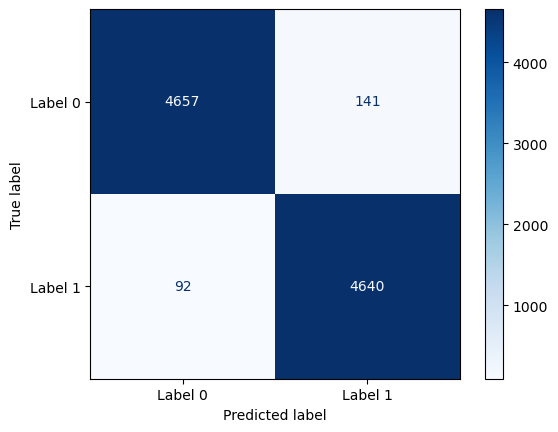

In [62]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test_le, nb_pred)

# Afficher la matrice de confusion
print("Confusion Matrix:")
print(conf_matrix)

# Optionnel : Afficher la matrice de confusion sous forme graphique
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Label 0', 'Label 1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


# CNN MODEL

In [63]:
from sklearn.model_selection import train_test_split

# Supprimer les lignes avec des classes ayant moins de deux membres
train_filtered = train.groupby('Label').filter(lambda x: len(x) > 1)

# Diviser les données en ensembles d'entraînement et de validation
data_train, data_valid, label_train, label_valid = train_test_split(train_filtered['tokens'].tolist(),
                                                                    train_filtered['Label'].tolist(),
                                                                    test_size=0.2,
                                                                    stratify=train_filtered['Label'].tolist(),
                                                                    random_state=0)

print('Train data len:', len(data_train))
print('Class distribution:', Counter(label_train))
print('Valid data len:', len(data_valid))
print('Class distribution:', Counter(label_valid))


Train data len: 38115
Class distribution: Counter({0: 19189, 1: 18926})
Valid data len: 9529
Class distribution: Counter({0: 4798, 1: 4731})


In [64]:
all_training_words = [word for tokens in data_train for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
max_train_len=max(training_sentence_lengths)
print("Max sentence length is %s" % max_train_len)

367928 words total, with a vocabulary size of 29994
Max sentence length is 23


In [65]:
all_valid_words = [word for tokens in data_valid for word in tokens]
valid_sentence_lengths = [len(tokens) for tokens in data_valid]
VALID_VOCAB = sorted(list(set(all_valid_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_valid_words), len(VALID_VOCAB)))
max_valid_len=max(valid_sentence_lengths)
print("Max sentence length is %s" % max_valid_len)

91560 words total, with a vocabulary size of 13849
Max sentence length is 21


In [66]:


# Créer un tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train)

# Convertir les données textuelles en séquences de nombres entiers
sequences_train = tokenizer.texts_to_sequences(data_train)
sequences_valid = tokenizer.texts_to_sequences(data_valid)

# Déterminer la longueur maximale des séquences
max_len_train = max(len(seq) for seq in sequences_train)
max_len_valid = max(len(seq) for seq in sequences_valid)
max_len_total = max(max_len_train, max_len_valid)

# Rembourrer les séquences pour qu'elles aient toutes la même longueur
x_train = pad_sequences(sequences_train, padding='post', maxlen=max_len_total)
x_valid = pad_sequences(sequences_valid, padding='post', maxlen=max_len_total)

# Convertir les séquences rembourrées en array numpy
x_train = np.array(x_train)
x_valid = np.array(x_valid)

print(x_train.shape)  # Vérifier la forme de x_train
print(x_valid.shape)  # Vérifier la forme de x_valid

print(x_train[0])

train_ds = tf.data.Dataset.from_tensor_slices((x_train,label_train))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,label_valid))



(38115, 23)
(9529, 23)
[2065 1852 1453  280  127 1491 1543    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


In [67]:
import gensim
from gensim import models
import gensim.downloader as api
 
wv = api.load('word2vec-google-news-300')
 
vec_traffic = wv['traffic']
print(vec_traffic.shape)
print(wv.most_similar('traffic'))

(300,)
[('Traffic', 0.723159670829773), ('trafffic', 0.6815808415412903), ('traffice', 0.6652184724807739), ('traffic_congestion', 0.6333498358726501), ('traffi_c', 0.6304296851158142), ('trafic', 0.6263606548309326), ('congestion', 0.6192522048950195), ('vehicular_traffic', 0.5799977779388428), ('Grothe_heaved_desperation', 0.5782520771026611), ('traf_fic', 0.5725342035293579)]


In [68]:
unique_words = len(VALID_VOCAB)+len(TRAINING_VOCAB)
total_words = unique_words + 1
skipped_words = 0
embedding_dim = 300 
embedding_matrix = np.zeros((total_words, embedding_dim))
for word, index in tokenizer.word_index.items():
    try:
        embedding_vector = wv[word]
    except:
        skipped_words = skipped_words+1
        pass
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
print("Embeddings Matrix shape : ",embedding_matrix[2])

Embeddings Matrix shape :  [ 0.0177002   0.06542969 -0.21972656 -0.12109375 -0.04296875 -0.06396484
 -0.28125    -0.41992188  0.33398438 -0.02770996  0.12451172 -0.10839844
  0.24511719  0.02600098 -0.25390625  0.02856445  0.05493164 -0.20214844
  0.22558594  0.07617188  0.36914062  0.33203125 -0.12597656 -0.15429688
  0.03613281 -0.00698853 -0.00062943 -0.24511719  0.0859375  -0.05834961
  0.12890625  0.07617188 -0.15722656 -0.38476562 -0.08837891  0.12890625
  0.11767578 -0.09082031 -0.31054688 -0.03173828  0.10253906 -0.15234375
  0.1484375  -0.140625   -0.14746094 -0.32421875 -0.23046875  0.13769531
  0.06030273  0.14355469 -0.32226562  0.09472656 -0.06738281 -0.03930664
  0.02453613 -0.17089844 -0.12792969 -0.06640625  0.05517578 -0.10546875
 -0.05493164 -0.10400391 -0.12988281 -0.23242188  0.0402832  -0.21289062
  0.14453125  0.07128906 -0.08300781 -0.03515625  0.07226562  0.08740234
  0.38671875 -0.00674438 -0.03930664 -0.11572266 -0.46484375  0.171875
 -0.21777344  0.22753906  

In [69]:
#creation d'une couche d'incorporation (embedding layer) pour un modèle de réseau neuronal
max_length=max_len_total

embedding_layer = Embedding(total_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)

In [70]:
model = tf.keras.Sequential()
model.add(embedding_layer)                                   

model.add(tf.keras.layers.Conv1D(128,2, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(2, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.005),\
                                bias_regularizer=regularizers.l2(0.005),))
                               
model.summary()
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 300)           13153200  
                                                                 
 conv1d (Conv1D)             (None, 22, 128)           76928     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 13230386 (50.47 MB)
Trainable params: 77186 (301.51 KB)
Non-trainable params: 13153200 (50.18 MB)
__________

In [71]:
# Fit the model using the train and test datasets.

x_train=np.array(x_train)
label_train=np.array(label_train)
x1_valid=np.array(x_valid)
label1_valid=np.array(label_valid)
l_train = to_categorical(label_train, 2)
l_valid = to_categorical(label1_valid, 2)
history = model.fit(x_train,l_train,
                    shuffle=False,
                    validation_data=(x1_valid, l_valid),
                    batch_size=64,
                    epochs=20,
                    verbose=1)

Epoch 1/20



596/596 [==============================] - 18s 26ms/step - loss: 0.2476 - accuracy: 0.9524 - val_loss: 0.1899 - val_accuracy: 0.9716
Epoch 2/20
596/596 [==============================] - 15s 26ms/step - loss: 0.1787 - accuracy: 0.9745 - val_loss: 0.1689 - val_accuracy: 0.9751
Epoch 3/20
596/596 [==============================] - 15s 25ms/step - loss: 0.1604 - accuracy: 0.9776 - val_loss: 0.1560 - val_accuracy: 0.9759
Epoch 4/20
596/596 [==============================] - 15s 25ms/step - loss: 0.1493 - accuracy: 0.9786 - val_loss: 0.1467 - val_accuracy: 0.9769
Epoch 5/20
596/596 [==============================] - 15s 25ms/step - loss: 0.1391 - accuracy: 0.9803 - val_loss: 0.1394 - val_accuracy: 0.9773
Epoch 6/20
596/596 [==============================] - 16s 27ms/step - loss: 0.1330 - accuracy: 0.9798 - val_loss: 0.1336 - val_accuracy: 0.9782
Epoch 7/20
596/596 [==============================] - 15s 25ms/step - loss: 0.1267 - accuracy: 0.9811 - val_loss: 0.1280 - val_accuracy: 0.9785
Epo

In [72]:
model.save("model.h5")

C:\Users\khand\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


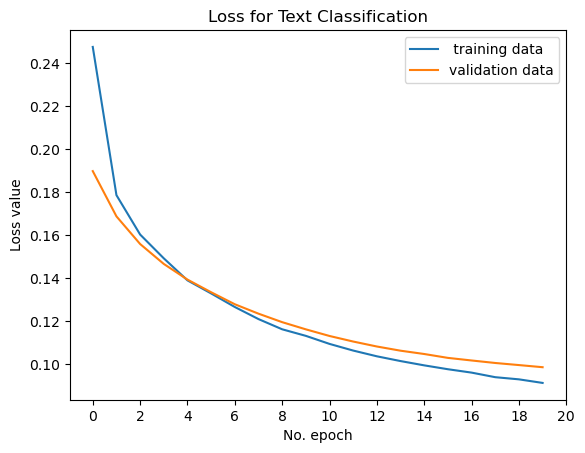

In [73]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.xticks(np.linspace(0, 20, 11))
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

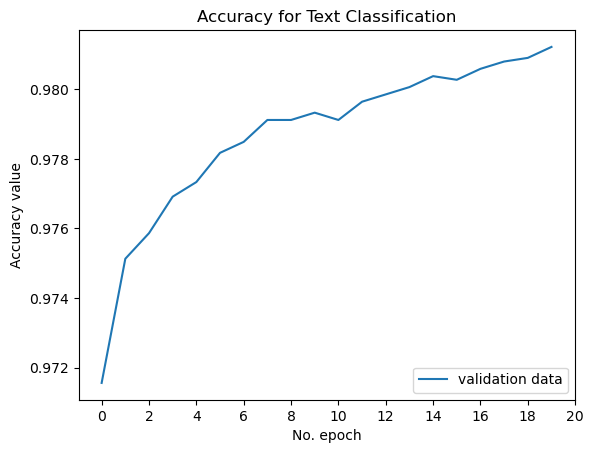

In [74]:
plt.plot(history.history['val_accuracy'], label='validation data')
plt.xticks(np.linspace(0, 20, 11))
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

In [75]:
y_pred_keras = model.predict(x_valid)
y_pred_keras = y_pred_keras[:, 1]  
print(y_pred_keras)


298/298 [==============================] - 3s 8ms/step
[0.09138672 0.96046615 0.11531188 ... 0.9610728  0.97192866 0.73429793]


In [76]:
s=label1_valid
print(s)

[0 1 0 ... 1 1 1]


Best Threshold=0.502887, G-Mean=0.981
AUC=0.998344


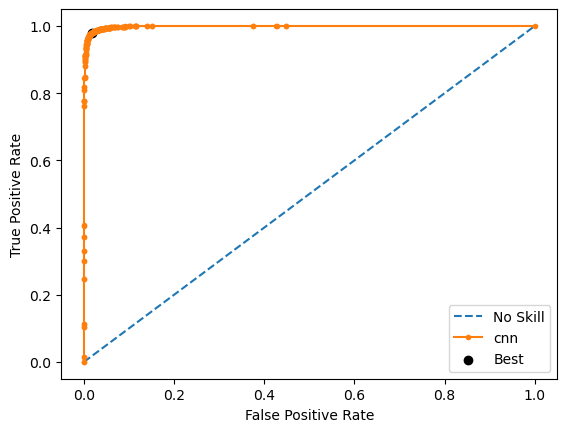

In [77]:
# évaluer visuellement la performance d'un modèle de classification binaire en termes de sensibilité (taux de vrais positifs) 
# et de spécificité (taux de faux positifs) sur différents seuils de classification.

from sklearn import metrics
fpr, tpr, thresholds = roc_curve(s, y_pred_keras)
roc_auc = metrics.auc(fpr, tpr)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
print('AUC=%f'% (roc_auc))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='cnn')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [78]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [79]:
cnf_matrix = confusion_matrix(s, y_pred_keras.round())
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[4713   85]
 [  94 4637]]


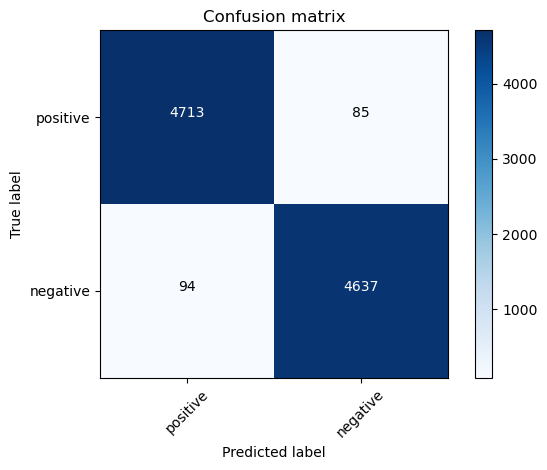

In [80]:
import itertools

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['positive','negative'],
                      title='Confusion matrix')

In [81]:
tn, fp, fn, tp = confusion_matrix(s, y_pred_keras.round()).ravel()
print(y_pred_keras.round())
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

[0. 1. 0. ... 1. 1. 1.]
True Negatives:  4713
False Positives:  85
False Negatives:  94
True Positives:  4637


In [82]:
new_model = tf.keras.models.load_model('model.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 300)           13153200  
                                                                 
 conv1d (Conv1D)             (None, 22, 128)           76928     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 13230386 (50.47 MB)
Trainable params: 77186 (301.51 KB)
Non-trainable params: 13153200 (50.18 MB)
__________

In [83]:
y_pred_probs = model.predict(x_valid)
threshold = 0.467496
y_pred = (y_pred_probs >= threshold).astype(int)
y_pred = y_pred.argmax(axis=1)
print(y_pred)


298/298 [==============================] - 2s 7ms/step
[0 1 0 ... 1 1 1]


In [87]:
y_pred = np.where((y_pred == 0),'negative',y_pred)
y_pred = np.where((y_pred == '1'),'positive',y_pred)
s = np.where((s == '0'),'negative',s)
s = np.where((s == '1'),'positive',s)
print(y_pred)
print(s)

['negative' 'positive' 'negative' ... 'positive' 'positive' 'positive']
['negative' 'positive' 'negative' ... 'positive' 'positive' 'positive']


In [88]:
y_test = s.tolist()
y_pred = y_pred.tolist()

In [89]:
labels=['negative','positive']
print(classification_report(y_test,y_pred,
                            labels=labels))

              precision    recall  f1-score   support

    negative       0.98      0.99      0.98      4798
    positive       0.99      0.98      0.98      4731

    accuracy                           0.98      9529
   macro avg       0.98      0.98      0.98      9529
weighted avg       0.98      0.98      0.98      9529



# BERT MODEL

In [50]:
import numpy as np
from transformers import AutoTokenizer


MAX_LEN = 128  # ou la valeur que vous souhaitez

# Initialisez votre tokenizer. Par exemple:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize(data, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

# Exemple d'utilisation avec X_train, X_valid, et X_test
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)


In [51]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [52]:
MAX_LEN = 128

def create_model(bert_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()
    
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')
    
    # Utilisation du modèle BERT
    bert_output = bert_model([input_ids, attention_masks])
    embeddings = bert_output[1]  
    
    # Couche Dense de sortie
    output = tf.keras.layers.Dense(1, activation="sigmoid")(embeddings)  
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])
    
    return model


model = create_model(bert_model, MAX_LEN)


model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [109]:
y_train_binary = y_train[:, 1]  
y_valid_binary = y_valid[:, 1]


history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train_binary,
    validation_data=([val_input_ids, val_attention_masks], y_valid_binary),
    epochs=4,
    batch_size=32
)
#tester les epochs

Epoch 1/4
1080/1080 [==============================] - 16416s 15s/step - loss: 0.0560 - binary_accuracy: 0.9809 - val_loss: 0.0419 - val_binary_accuracy: 0.9849
Epoch 2/4
1080/1080 [==============================] - 17869s 17s/step - loss: 0.0237 - binary_accuracy: 0.9908 - val_loss: 0.0499 - val_binary_accuracy: 0.9831
Epoch 3/4
1080/1080 [==============================] - 20271s 19s/step - loss: 0.0106 - binary_accuracy: 0.9961 - val_loss: 0.0520 - val_binary_accuracy: 0.9841
Epoch 4/4
1080/1080 [==============================] - 16979s 16s/step - loss: 0.0070 - binary_accuracy: 0.9975 - val_loss: 0.0615 - val_binary_accuracy: 0.9865


In [131]:
result_bert = model.predict([test_input_ids,test_attention_masks])

298/298 [==============================] - 1779s 6s/step


In [143]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1


In [144]:
from sklearn.metrics import confusion_matrix

# Prédiction des classes sur les données de validation
y_pred = model.predict([val_input_ids, val_attention_masks])
y_pred_classes = np.round(y_pred).astype(int)  



120/120 [==============================] - 574s 5s/step


In [134]:
import numpy as np

# Aplatir les tableaux multidimensionnels en un tableau unidimensionnel
y_valid_flat = np.array(y_valid).flatten()
y_pred_classes_flat = np.array(y_pred_classes).flatten()

# Vérifier si les tableaux aplaties ne contiennent que des valeurs binaires
if np.all(np.logical_or(y_valid_flat == 0, y_valid_flat == 1)):
    print("y_valid_flat ne contient que des valeurs binaires (0 ou 1).")
else:
    print("y_valid_flat contient des valeurs qui ne sont pas binaires.")

if np.all(np.logical_or(y_pred_classes_flat == 0, y_pred_classes_flat == 1)):
    print("y_pred_classes_flat ne contient que des valeurs binaires (0 ou 1).")
else:
    print("y_pred_classes_flat contient des valeurs qui ne sont pas binaires.")


y_valid_flat ne contient que des valeurs binaires (0 ou 1).
y_pred_classes_flat ne contient que des valeurs binaires (0 ou 1).


In [135]:
# Vérifier les dimensions
print("Longueur de y_valid:", len(y_valid))
print("Longueur de y_pred_classes:", len(y_pred_classes))

# Comparer les valeurs
print("Quelques échantillons de y_valid:", y_valid[:10])
print("Quelques échantillons de y_pred_classes:", y_pred_classes[:10])

# Vérifier si les valeurs correspondent
correspondance = (y_valid == y_pred_classes)
print("Correspondance entre y_valid et y_pred_classes:", correspondance)
print("Nombre de correspondances:", sum(correspondance))


Longueur de y_valid: 3838
Longueur de y_pred_classes: 3838
Quelques échantillons de y_valid: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Quelques échantillons de y_pred_classes: [[0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]]
Correspondance entre y_valid et y_pred_classes: [[ True False]
 [False  True]
 [False  True]
 ...
 [False  True]
 [False  True]
 [False  True]]
Nombre de correspondances: [  52 3786]


In [139]:
# Convertir y_pred_classes en un format similaire à y_valid
y_pred_classes_multilabel = np.zeros_like(y_valid)
y_pred_classes_multilabel[np.arange(len(y_pred_classes)), y_pred_classes.flatten()] = 1

# Vérifier si les deux tableaux sont maintenant dans le même format
print("Shape de y_valid:", y_valid.shape)
print("Shape de y_pred_classes_multilabel:", y_pred_classes_multilabel.shape)



Shape de y_valid: (3838, 2)
Shape de y_pred_classes: (3838, 2)


In [122]:
from sklearn.metrics import accuracy_score

# Calcul de l'exactitude
accuracy = accuracy_score(y_valid, y_pred_classes)

# Affichage de l'exactitude
print(f"Accuracy : {accuracy}")


Accuracy : 0.986451276706618


In [120]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcul 
precision = precision_score(y_valid, y_pred_classes, average=None)
recall = recall_score(y_valid, y_pred_classes, average=None)
f1 = f1_score(y_valid, y_pred_classes, average=None)
# Affichage
for i in range(len(precision)):
    print(f"Classe {i}: Precision={precision[i]}, Recall={recall[i]}, F1-Score={f1[i]}")


Classe 0: Precision=0.9889994761655317, Recall=0.9838457529963522, F1-Score=0.9864158829676071
Classe 1: Precision=0.9839294971487818, Recall=0.9890568004168838, F1-Score=0.9864864864864865


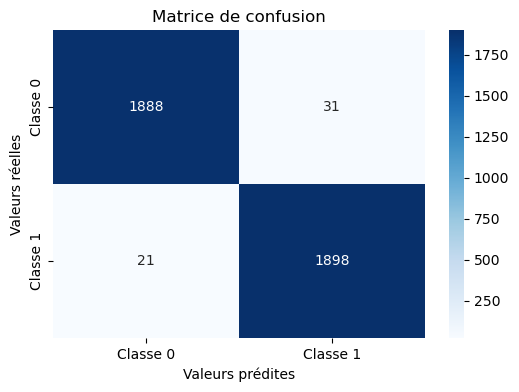

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_valid.argmax(axis=1), y_pred_classes_multilabel.argmax(axis=1))
# Affichage
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='d', xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()


# Roberta Model

In [73]:
tokenizer = AutoTokenizer.from_pretrained("jplu/tf-xlm-roberta-large")

In [56]:
MAX_LEN = 192
def preprocess(data, max_seq_length = MAX_LEN, tokenizer = tokenizer):    
    ids = []
    masks = []
    segment = []
    for i in (range(len(data))):
        
        tokens = tokenizer.tokenize(data[i])
        if len(tokens) > max_seq_length - 2:
            tokens = tokens[ : max_seq_length - 2]

        # Converting tokens to ids
        input_ids = tokenizer.convert_tokens_to_ids(["[CLS]"] + tokens + ["[SEP]"])
        # Added [CLS] and [SEP] as required to BERT Model

        # Input mask
        input_masks = [1] * len(input_ids)

        # padding upto max length
        padding = max_seq_length - len(input_ids)
        input_ids.extend([0] * padding)
        input_masks.extend([0] * padding)
        segment_ids =[0]* max_seq_length
        
        
        ids.append(input_ids)
        masks.append(input_masks)
        segment.append(segment_ids)
    
    return (np.array(ids), np.array(masks), np.array(segment))

In [113]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_ids, train_masks, train_segment =  preprocess(df['text_clean'].values)
test_ids, test_masks, test_segment =  preprocess(df_test['text_clean'].values)


In [102]:
# train_ids, train_masks, train_segment =  preprocess(X_train,MAX_LEN )
# val_ids, val_masks, val_segment = preprocess(X_valid, MAX_LEN)
# test_ids, test_masks, test_segment = preprocess(X_test, MAX_LEN)


In [103]:
# import numpy as np

# # Concaténation des données d'entraînement et de validation
# concatenated_train_ids = np.concatenate((train_ids, val_ids), axis=0)
# concatenated_train_masks = np.concatenate((train_masks, val_masks), axis=0)
# concatenated_train_segment = np.concatenate((train_segment, val_segment), axis=0)


In [115]:
yy_train = df['Label'].values


In [116]:
import tensorflow as tf

# Définition de la stratégie de distribution (par exemple, pour utiliser les GPU)
strategy = tf.distribute.MirroredStrategy()

# Définition de la taille de lot (batch size) en fonction du nombre de répliques dans la stratégie
BATCH_SIZE = 16 * strategy.num_replicas_in_sync


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [117]:
def model(roberta_layer, max_len = MAX_LEN):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    pooled_output, sequence_output = roberta_layer([input_word_ids, input_mask, segment_ids])

    # There are two outputs: a pooled_output of shape [batch_size, 768] with representations for 
    # the entire input sequences and a sequence_output of shape [batch_size, max_seq_length, 768] 
    # with representations for each input token (in context)


    x = pooled_output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(256, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    
    model = tf.keras.Model(inputs = [input_word_ids, input_mask, segment_ids], outputs = x)
    
    return model

In [118]:
import tensorflow as tf
from transformers import TFAutoModel

# Définition de la stratégie de distribution (par exemple, pour utiliser les GPU)
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Charger le modèle RoBERTa
    roberta_layer = TFAutoModel.from_pretrained("jplu/tf-xlm-roberta-large", trainable=True)

    # Définir le reste du modèle
    input_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32)
    attention_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32)
    token_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32)

    outputs = roberta_layer(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    # Ajouter vos couches personnalisées
    pooled_output = outputs[1]  # Utilisez la sortie "pooled_output" pour une classification de séquence
    x = tf.keras.layers.Flatten()(pooled_output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Définir le modèle
    model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=outputs)

    # Compiler le modèle
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

# Afficher un résumé du modèle
model.summary()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Some layers from the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 192)]                0         []                            
                                                                                                  
 input_13 (InputLayer)       [(None, 192)]                0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 192)]                0         []                            
                                                                                                  
 tfxlm_roberta_model_4 (TFX  TFBaseModelOutputWithPooli   5598904   ['input_12[0][0]',            
 LMRobertaModel)             ngAndCrossAttentions(last_   32         'input_13[0][0]',      

C:\Users\khand\anaconda3\Lib\site-packages\keras\src\utils\layer_utils.py:146: RuntimeWarning: overflow encountered in scalar add
  total_memory_size += weight_shape * per_param_size


In [119]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 4, shuffle = True)
skf.get_n_splits(train_ids, yy_train)
skf

StratifiedKFold(n_splits=4, random_state=None, shuffle=True)

In [120]:
# Trouver les indices des valeurs NaN dans vos données
nan_indices = np.isnan(yy_train_array)

# Calculer la moyenne de chaque colonne
mean_values = np.nanmean(yy_train_array, axis=0)

# Remplacer les valeurs NaN par la moyenne de chaque colonne
yy_train_array = np.where(nan_indices, mean_values, yy_train_array)


In [ ]:
i = 1
preds = []
for train_index, test_index in skf.split(train_ids, yy_train):
    print("\n")
    print("#" * 20)
    print(f"FOLD No {i}")
    print("#" * 20)
    
    
    tr_ids = train_ids[train_index]
    tr_masks = train_masks[train_index]
    tr_segment = train_segment[train_index]
    
    vd_ids = train_ids[test_index]
    vd_masks = train_masks[test_index]
    vd_segment = train_segment[test_index]
    
    y_tr = y_train[train_index]
    y_vd = y_train[test_index]
    
    
    history = model.fit(
    (tr_ids, tr_masks, tr_segment), y_tr,epochs=2,batch_size=BATCH_SIZE,validation_data = ((vd_ids, vd_masks, vd_segment), y_vd),
    steps_per_epoch = len(tr_ids)//BATCH_SIZE)

    predictions = model.predict((test_ids, test_masks, test_segment))
    preds.append(predictions)
    
    i += 1
    K.clear_session()




####################
FOLD No 1
####################
Epoch 1/2



  21/1786 [..............................] - ETA: 120:38:56 - loss: 1.2697 - accuracy: 0.4643